In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import csv
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from IPython.display import clear_output

torch.set_printoptions(threshold=float('inf'))
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["TORCH_USE_CUDA_DSA"] = "1"

device = "cuda:0"
address = fr"C:/Users/sjw00/OneDrive/Desktop/dataset/CIFAR_10"

temp_list = list()
r=open(address+'/training_data_CIFAR.csv', 'r' )
reader=csv.reader(r)
for i, target in enumerate(reader):
    temp_list.append(target)

training_data = np.array(temp_list).reshape((-1, 3, 32, 32)).astype(float)*2/255-1
training_data = torch.from_numpy(training_data).type(torch.FloatTensor).to(device)
print(training_data.shape, training_data.dtype)

batch_size = 800
training_dataset = TensorDataset(training_data)
training_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)


torch.Size([50000, 3, 32, 32]) torch.float32


In [2]:
latent_dim = 128  # 잠재 공간 차원
hidden_dim = 512
batch_size = 256

class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAE, self).__init__()

        # 🔹 Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),  # 32x32 → 16x16
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 16x16 → 8x8
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 8x8 → 4x4
            nn.ReLU(),
            nn.Flatten()
        )

        self.fc_mu = nn.Linear(256 * 4 * 4, latent_dim)  # 평균 μ
        self.fc_logvar = nn.Linear(256 * 4 * 4, latent_dim)  # 로그 분산 log(σ^2)

        # 🔹 Decoder
        self.fc_dec = nn.Linear(latent_dim, 256 * 4 * 4)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 4x4 → 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 8x8 → 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),  # 16x16 → 32x32
            nn.Tanh()  # 출력 값을 [-1, 1] 범위로 정규화
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)  # 표준편차 σ 계산
        eps = torch.randn_like(std)  # N(0,1) 샘플링
        return mu + eps * std  # z = μ + σ * ε (Reparameterization Trick)

    def decode(self, z):
        h = self.fc_dec(z).view(-1, 256, 4, 4)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# ✅ 손실 함수 정의 (Reconstruction Loss + KL Divergence)
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.mse_loss(recon_x, x, reduction='sum')  # 복원 손실
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())  # KL Divergence
    return BCE + KLD

def generate_images(model, num_images=8):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_images, latent_dim, device=device)  # 무작위 잠재 벡터 샘플링
        samples = model.decode(z).cpu()  # 생성된 이미지

    samples = (samples + 1) / 2  # [-1,1] → [0,1] 변환
    samples = torch.clamp(samples, 0, 1)  # 값 조정

    # 🔹 결과 시각화
    fig, axes = plt.subplots(1, num_images, figsize=(15, 15))
    for i, img in enumerate(samples):
        img = img.permute(1, 2, 0).numpy()  # (C, H, W) → (H, W, C)
        axes[i].imshow(img)
        axes[i].axis("off")
    plt.show()

Epoch [2769/5000], Loss: 168.4509


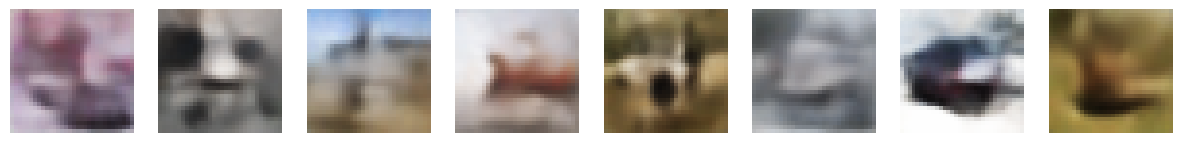

KeyboardInterrupt: 

In [3]:
model = VAE(latent_dim=latent_dim).to(device)

scaler = torch.amp.GradScaler()
# 옵티마이저 설정
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5)
# 손실 함수
loss_fn = nn.MSELoss(reduction='sum')


# 학습 루프
num_epochs = 5000
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch_idx, (data,) in enumerate(training_dataloader):  # x0는 원본 이미지
        # 모델이 노이즈를 얼마나 잘 예측하는지 확인
        with torch.autocast(device_type='cuda', dtype=torch.bfloat16):
            recon_batch, mu, logvar = model(data) # Forward pass: generate predictions
            loss = loss_function(recon_batch, data, mu, logvar)
        optimizer.zero_grad()
        scaler.scale(loss).backward() # Backpropagation: compute gradients
        scaler.step(optimizer) # Update model parameters using the optimizer
        epoch_loss+=loss.item() # Accumulate batch loss
        scaler.update() # Update the gradient scaler
    scheduler.step()
    average_loss = epoch_loss / 50000
    clear_output(wait=True)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}")
    generate_images(model)


In [ ]:
torch.save({
                'epoch': epoch + 1,
                'model': model.state_dict(),  
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                "scaler": scaler.state_dict(),
            }, fr"D:\model_save\epoch_{epoch}_{model.__class__.__name__}_{device[-1]}_{optimizer.param_groups[0]['lr']}.pt")

In [ ]:
model = UNet().to(device)
diffusion = Diffusion()
scaler = torch.amp.GradScaler()
# 옵티마이저 설정
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5)
# 손실 함수
loss_fn = nn.MSELoss(reduction='sum')
print("Loading checkpoint...")

loadfilepath = fr"D:\model_save\epoch_1838_UNet_1_0.0005.pt" #D:\model_save\epoch_32_ResNet_0_71.758_0.0001.pt 1e-5 1e-4
lr = 1e-4

checkpoint = torch.load(loadfilepath, map_location=device)
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
scaler.load_state_dict(checkpoint['scaler'])
start_epoch = checkpoint['epoch']
print(f"Resuming from epoch {start_epoch}.")
optimizer.param_groups[0]['lr'] = lr
print(optimizer.param_groups[0]['lr'])

Loading checkpoint...


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_18504\3626571315.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(loadfilepath, map_locat

Resuming from epoch 1839.
0.0001


In [ ]:
num_epochs=5000
optimizer.param_groups[0]['lr'] = 1e-3
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for x0, in training_dataloader:  # x0는 원본 이미지
        
        # 무작위 t 샘플링
        t = torch.randint(0, diffusion.T, (x0.shape[0],), device=device) # [batch_size]

        # x_t 생성
        x_t, noise = diffusion.forward_diffusion(x0, t)
        
        # 모델이 노이즈를 얼마나 잘 예측하는지 확인
        with torch.autocast(device_type='cuda', dtype=torch.bfloat16):
            noise_pred = model(x_t, t) # Forward pass: generate predictions
            loss = loss_fn(noise_pred, noise) # Compute the loss for the batch
        optimizer.zero_grad()
        scaler.scale(loss).backward() # Backpropagation: compute gradients
        scaler.step(optimizer) # Update model parameters using the optimizer
        epoch_loss+=loss.item() # Accumulate batch loss
        scaler.update() # Update the gradient scaler
    scheduler.step()
    average_loss = epoch_loss / 50000
    clear_output(wait=True)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}")

    img_size = (3, 32, 32)
    num_samples = 8

    # 모델을 평가 모드로 설정
    model.eval()

    with torch.no_grad():
        generated_images = diffusion.reverse_diffusion(model, img_size, num_samples)

    # 결과 시각화
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 15))
    for i, img in enumerate(generated_images):
        img = img.cpu().numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
        img = (img + 1) / 2  # 정규화 해제 (-1~1 -> 0~1)
        img = np.clip(img, 0, 1)
        
        
        axes[i].imshow(img)
        axes[i].axis("off")
    plt.show()

Epoch [139/5000], Loss: 85.5336
